## Project 3 - Processing Notebook for 'Warriors' and 'Lakers' Subreddit Dataframes
#### Stephen Strawbridge, Cohort #1019
---

In [1]:
#Standard packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Natural langauge toolkit
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

#Scikit learn
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import requests
from bs4 import BeautifulSoup

## Merge dataframes together
---

In [2]:
#First, read-in/import dataframes
warriors_df = pd.read_csv('./cleaned_dfs/df_warriors_clean.csv')
lakers_df = pd.read_csv('./cleaned_dfs/df_lakers_clean.csv')

In [3]:
#Merge dataframes using concatenate function (merge by column names)
merged_df = pd.concat([warriors_df, lakers_df])

In [4]:
#Because title and selftext have been combined into a wholepost column, the title and selftext column will be dropped
merged_df = merged_df.drop(columns=['title', 'selftext'])

In [5]:
#Double check no nulls are in dataframe
merged_df.isnull().sum()

subreddit     0
whole_post    0
dtype: int64

In [6]:
#Replace subreddit column with 1 for 'warriors' and 0 for 'lakers' in order to binarize the labels
merged_df['subreddit'] = merged_df['subreddit'].map({'warriors':1, 'lakers':0}) 

In [7]:
#Reset index
merged_df = merged_df.reset_index(drop=True)

In [8]:
#Lowercase all text in the 'whole_post' column
merged_df['whole_post'] = merged_df['whole_post'].str.lower()

In [9]:
#Check on layout of dataframe
merged_df.head(3)

,subreddit,whole_post
0,1,coming to an arena near you
1,1,steph curry nba mix~ flex (polo g x juice wrld)
2,1,two warriors players test positive for covid-1...


In [10]:
#Check on layout of dataframe
merged_df.tail(3)

,subreddit,whole_post
9952,0,"lakers free agency questions,can the lakers us..."
9953,0,the real story behind who lebron james was fac...
9954,0,new assistant gm?? 👀


In [11]:
#merged_df.to_csv('./cleaned_dfs/merged_df.csv')

## Multinomial Naive Bayes Model - With CountVectorizer
---

Now we adjust the hyperparameters of countvectorizer and use pipeline/gridsearch to get our optimal model.

In [12]:
cvec = CountVectorizer()

In [13]:
#Source code is leveraged from GA lesson 5.04

#Define X and y
X = merged_df['whole_post']
y = merged_df['subreddit']

#Train-test-split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.30,
                                                    stratify=y,
                                                    random_state=35)

In [14]:
#Adding to list of stopwords, as described in further detail below
#Source code: https://medium.com/@tusharsri/remove-add-stop-words-7e2994c19c67#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6IjJlMzAyNWYyNmI1OTVmOTZlYWM5MDdjYzJiOTQ3MTQyMmJjYWViOTMiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJuYmYiOjE2MDY3ODYwMTYsImF1ZCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsInN1YiI6IjExODAzOTU2ODk0Mjc2MDYwNDEzNCIsImVtYWlsIjoic3RlcGhlbnN0cmF3YnJpZGdlQGdtYWlsLmNvbSIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJuYW1lIjoiU3RlcGhlbiBTdHJhd2JyaWRnZSIsInBpY3R1cmUiOiJodHRwczovL2xoMy5nb29nbGV1c2VyY29udGVudC5jb20vYS0vQU9oMTRHZ041UTZGNk9TRFM3TllUSHdWa0pObTVHQ1FpWkR5THlkMVNHTlA9czk2LWMiLCJnaXZlbl9uYW1lIjoiU3RlcGhlbiIsImZhbWlseV9uYW1lIjoiU3RyYXdicmlkZ2UiLCJpYXQiOjE2MDY3ODYzMTYsImV4cCI6MTYwNjc4OTkxNiwianRpIjoiNTE1ODAwOGRjMTJmYWYzNDVkYTQzYjVjNzdkOWQxMzA1MmEzMjIzYyJ9.Hdn15nX8ADSK9JZBI-y2KgdjVRYZIv3_QIQdco0XA7-t-MEMANDGFpbkffLwlG0CciRwWN5pIgrG2y-9xcdnAQ9gMl0MEBKCLorh4iHWMcCHmLLUnl70yvXrzihlmugq3tKHeOD8JXnjIBsWGcYnoH_FMSwQZ7bAqx_6ldc7Lb_W77dBn1RlIvG2BKaRcu7xkM-bC1-Pru-7OaVw9SMdVqK_TiTeS1kaEgsJAdRWJQKXXHNikBuAnd8dQp9Wp6OC2UAPilHFF79hidc49SQXOdrkstbMDVZOmcQCj8QNe_pF0E47alEK3ClILnF0UUYH5KwyMQC6wey5-ZN_kzmdpA

#Import text package from sklearn
from sklearn.feature_extraction import text

#Create list of new stop words to include in the default English list of stop words
new_stop_words = ['www', 'com', 'https', 'reddit', 'think', 'like', 'index', 'wiki', 'just']
english_stops = (CountVectorizer(stop_words = 'english').get_stop_words)

#Create a final variable of STOP_WORDS to use
stop_words = text.ENGLISH_STOP_WORDS.union(new_stop_words)

In [15]:
#Set up pipeline with countvectorizer as the transformer, and multinomial Naive Bayes as the estimator
pipe = Pipeline([
    ('cvec', CountVectorizer(tokenizer = None,
                       stop_words = stop_words)),
    ('nb', MultinomialNB())
])


In [16]:
#Fit model on training set
pipe.fit(X_train, y_train);

#### Hyperparameters used in Countvectorizer:
* **tokenizer**: Tokenize data into chunks based on some distinct pattern.  These chunks will hold more prediction value.

* **stop_words**:  The english stopwords are used to eliminate irrelevant words that have no prediction value.  As seen above, I have also added words that appeared most frequently but hold no prediction value ('www', 'com' etc).

In [17]:
#Create pipe parameters to search over
pipe_params = {
    'cvec__max_features' : [8500, 9000, 9500],
    'cvec__min_df' : [1, 2],
    'cvec__max_df' : [.30, .40, .50],
    'cvec__ngram_range' : [(1, 1)],
}

#### Hyperparameters used in Pipeline Parameters:
* **cvec__max_features**: Max features optimal point was about 9,000.

* **cvec__min_df and cvec__max_df**: These appear to have very little effect on model.

* **cvec__ngram_range**: A lower and upper boundary of 1 was most optimal.

In [18]:
#Instantiate Gridsearch on training set (use variables made in previous steps)
gs = GridSearchCV(estimator=pipe,
                  param_grid = pipe_params, 
                  cv = 5) #5 cross validation folds on each of the parameters

In [19]:
#Fit gridsearch on training set
gs.fit(X_train, y_train);

In [20]:
#Find best score
gs.best_score_

0.8764367028831387

In [21]:
#Find best params
gs.best_params_

{'cvec__max_df': 0.3,
 'cvec__max_features': 9000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1)}

In [22]:
#Find score on training and modeling set
train_score = gs.score(X_train, y_train)
test_score = gs.score(X_test, y_test)

print(f'Train Score: {round(train_score, 4)}')
print(f'Test Score: {round(test_score, 4)}')

Train Score: 0.9152
Test Score: 0.8661


In [23]:
#Baseline score/accuracy
y_test.value_counts(normalize=True)

1    0.500502
0    0.499498
Name: subreddit, dtype: float64

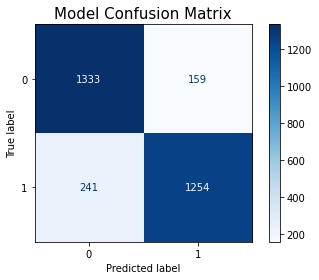

In [24]:
# Create predictions variable
pred = gs.predict(X_test)

# Create confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

#Create confusion matrix visual
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues');
plt.title('Model Confusion Matrix', size=15);

## Multinomial Naive Bayes Model - With TF-IDF Vectorizer
---

In [25]:
#Source code is leveraged from GA lesson, 5.04
# Instantiate the transformer (TfidVectorizer)
tvec = TfidfVectorizer()

In [26]:
#Set up pipeline with tfidvectorizer as the transformer, and multinomial Naive Bayes as the estimator
tvec_pipe = Pipeline([
    ('tvec' , TfidfVectorizer(tokenizer = None,
                       stop_words = stop_words)),
    ('nb', MultinomialNB())
])

In [27]:
#Create pipe parameters to search over
pipe_params_tvec = {
    'tvec__max_features' : [2_000, 3_000, 8_000, 9_000],
    'tvec__ngram_range' : [(1,1), (1,2), (1,3), (2, 2)],
    'tvec__stop_words' : [None, 'english', stop_words]
}

#### Hyperparameters used in Pipeline Parameters:
* **tvec__max_features**: Max features optimal point was about 9,000.  It was noted that without this parameter, our testing score slightly improved but our training score WAY overimproved, making the model WAY too overfit.

* **tvec__ngram_range**: A lower upper boundary of 1, and upper boundary of 2 was most optimal.

* **tvec__ngram_range**: Our created list of stop_words was a success, as this list was the most optimal parameter.

In [28]:
#Instantiate GridSearchCV
gs_tvec = GridSearchCV(tvec_pipe,
                      pipe_params_tvec,
                      cv = 5)

In [29]:
#Fit GridSearch to training data
gs_tvec.fit(X_train, y_train);

In [30]:
#Find best parameters
gs_tvec.best_params_;

In [31]:
#Best score among the gridsearch
gs_tvec.best_score_

0.8734239963910555

In [32]:
#Find score on training and modeling set
train_score = gs_tvec.score(X_train, y_train)
test_score = gs_tvec.score(X_test, y_test)

print(f'Train Score: {round(train_score, 4)}')
print(f'Test Score: {round(test_score, 4)}')

Train Score: 0.9284
Test Score: 0.8694


In [33]:
#Recall Baseline score/accuracy
y_test.value_counts(normalize=True)

1    0.500502
0    0.499498
Name: subreddit, dtype: float64

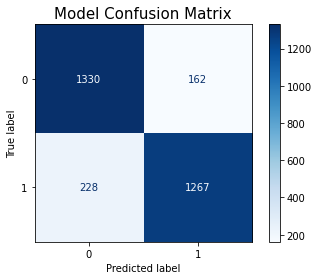

In [34]:
# Create predictions variable
pred = gs_tvec.predict(X_test)

# Create confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

#Create confusion matrix visual
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues');
plt.title('Model Confusion Matrix', size=15);

## Random Forests Model - With TF-IDF Vectorizer (and Bootstrapping)
---

In [35]:
#Source code is leveraged from GA lesson 6.03

#Define X and y
X = merged_df['whole_post']
y = merged_df['subreddit']

In [36]:
#Train-test-split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.30,
                                                    stratify=y,
                                                    random_state=35)

In [37]:
#Tfidvectorizer X and Y variables
tvec = TfidfVectorizer()

#Apply the transformer to training data for modeling
X_train = tvec.fit_transform(X_train)

#Apply transformer to testing data to be used for analysis later
X_test = tvec.transform(X_test)

In [38]:
#Instantiate Random Forest Classifier
rf = RandomForestClassifier()

In [39]:
#Initial model evaluation
cross_val_score(rf, X_train, y_train, cv=5).mean()

0.86567290232676

#### GridSearch over the model

In [40]:
#From these model parameters, we make a dictionary to save our best parameters
#Note that we do NOT re-run this cell, as this would restart the dataframe

#model_params = {}
#count = 0

In [41]:
#Rerun this cell to save parameters to dataframe

rf = RandomForestClassifier(random_state=35, n_jobs = 4)  #Note, I have a 4 core processor (n_jobs is just used for speed, max you should ever put in is twice your processor)

params = {
    'n_estimators' : [125],  #number of trees in model
    'max_features' : [None, 'auto'], #number of features the model should consider when splitting
    'max_depth' : [50, 60, 70],
    'ccp_alpha' : [0, 0.001, 0.01]
}

gs = GridSearchCV(rf, param_grid=params, cv=5)

gs.fit(X_train, y_train)

count += 1

gs.best_params_['score'] = gs.best_score_

model_params[f'model_{count}'] = gs.best_params_

model_df = pd.DataFrame.from_dict(model_params, orient='index')

model_df  #Save to 'best_param_dfs' folder 

,n_estimators,score
model_1,125,0.867396


* n_estimators:  Number of trees we're making.  More trees is not necessarily better, because parameters interact with each other.

* max_features: Number of features (which in this case, is words) is considered.  None means every single word is included.  Auto would mean we use the square root of the number of words.

* max_depth:  How deep each tree goes. 

* cc_alpha: Picks the most complex model.  The alpha value limits how complex the model will become.


In [42]:
#Find score on training and modeling set
train_score = gs.score(X_train, y_train)

print(f'Train Score: {round(train_score, 4)}')

Train Score: 0.9973


In [43]:
#Find score on training and modeling set
test_score = gs.score(X_test, y_test)

print(f'Test Score: {round(test_score, 4)}')

Test Score: 0.8775
